In [1]:
import torch
import torchvision
from torchvision import models
import torchvision.transforms as T

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches
import cv2 as cv

print('pytorch', torch.__version__)
print('torchvision', torchvision.__version__)

c:\Users\th070\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


pytorch 1.13.1+cpu
torchvision 0.14.1+cpu


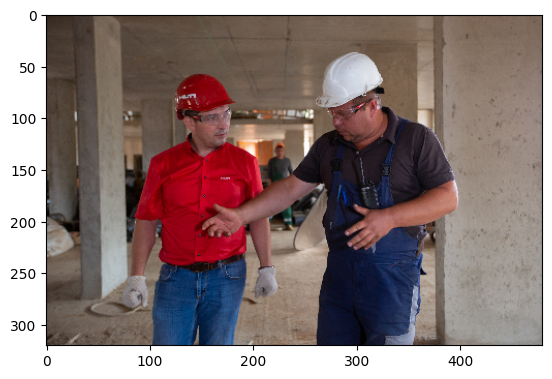

In [2]:
img = cv.imread(r'E:\GithubProjects\KagglePractice\HelmetDetection2\RawDatasets\pexels-aleksey-3680959.jpg')
Height, Width = img.shape[:2]
# Width : Height = 480 : ?
# ? = 480 * Height / Width
img = cv.resize(img, (480, int(480 * Height / Width)))

plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))

In [3]:
THRESHOLD = 0.95
OFFSET = 5
NORMALIZE_SIZE = (100, 100)
# NORMALIZE_SIZE = (-1, -1)

In [4]:
model = models.detection.keypointrcnn_resnet50_fpn(pretrained=True).eval()

c:\Users\th070\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\th070\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=KeypointRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=KeypointRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
trf = T.Compose([
	T.ToTensor()
])

input_img = trf(img)

out = model([input_img])[0]

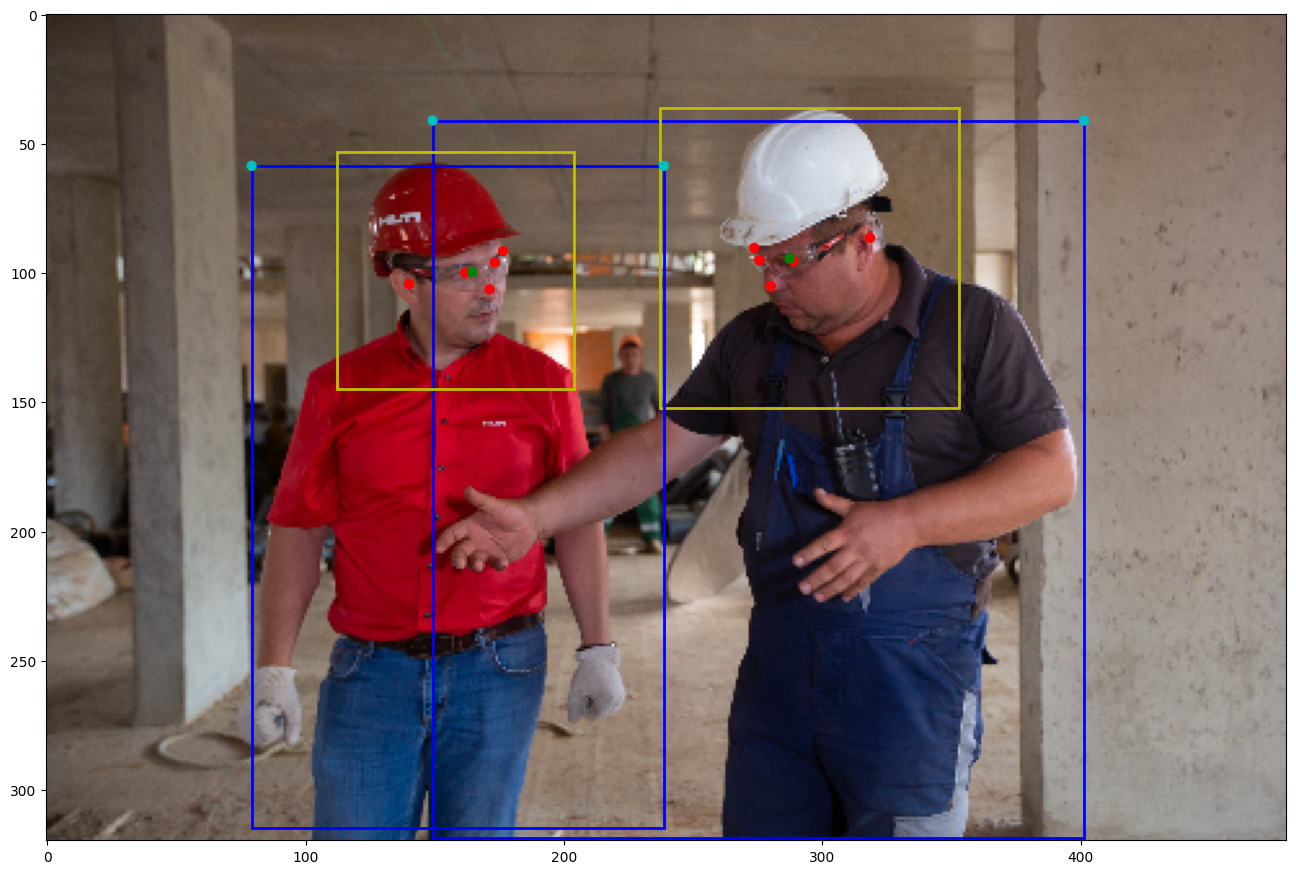

In [6]:
codes = [
    Path.MOVETO,
    Path.LINETO,
    Path.LINETO
]

fig, ax = plt.subplots(1, figsize=(16, 16))
ax.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))

HeadDict = {}
HeadDict['originalimg'] = img.copy()
HeadList = []

for box, score, keypoints in zip(out['boxes'], out['scores'], out['keypoints']):
	score = score.detach().numpy()

	if score < THRESHOLD: # 정확도가 낮으면 사람 아님
		continue
	BoxSize = abs((box[2] - box[0]) * (box[3] - box[1]))
	if BoxSize < 4000: # 상자 크기가 4000 보다 작으면 사람 아닌 것으로 치부함
		continue

	box = box.detach().numpy()
	keypoints = keypoints.detach().numpy()[:, :2]

	rect = patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], linewidth=2, edgecolor='b', facecolor='none')
	ax.add_patch(rect)
	x0, y0, x1, y1 = box
	# x0, y0 : 좌측 상단
	# x1, y1 : 우측 하단
	ax.add_patch(patches.Circle((x0, y0), radius=2, facecolor='c'))
	ax.add_patch(patches.Circle((x1, y0), radius=2, facecolor='c'))

	# 머리 쪽만 확인
	HeadPointLocs = []
	for k in keypoints[:5]:
		circle = patches.Circle((k[0], k[1]), radius=2, facecolor='r')
		HeadPointLocs.append((k[0], k[1]))
		ax.add_patch(circle)
	LeftEarX = int(keypoints[4][0])
	RightEarX = int(keypoints[3][0])
	
	# 머리 키 포인트들의 중심점을 구합니다
	HeadMiddlePoint = (sum(map(lambda x : x[0], HeadPointLocs)) / len(HeadPointLocs),
					   sum(map(lambda x : x[1], HeadPointLocs)) / len(HeadPointLocs))
	ax.add_patch(patches.Circle(HeadMiddlePoint, radius=2, facecolor='g'))

	MiddleX,MiddleY = int((LeftEarX + RightEarX)/2), int(HeadMiddlePoint[1])
	RadiusValue = int(OFFSET + (HeadMiddlePoint[1] - y0))
	x0,x1 = MiddleX - RadiusValue, MiddleX + RadiusValue
	y0,y1 = MiddleY - RadiusValue, MiddleY + RadiusValue
	# 머리 부분을 구합니다

	rect = patches.Rectangle((x0, y0), x1 - x0, y1 - y0, linewidth=2, edgecolor='y', facecolor='none')

	HeadImage = np.asarray(img)[y0:y1,x0:x1]
	if NORMALIZE_SIZE != (-1, -1):
		HeadImage = cv.resize(HeadImage, NORMALIZE_SIZE)
	else:
		pass
	ax.add_patch(rect)
	HeadList.append({
		"head" : HeadImage,
		"headpos" : (x0, y0, x1, y1),
		"bodypos" : (int(box[0]),int(box[1]),int(box[2]),int(box[3]))
	})
HeadDict['headlist'] = HeadList

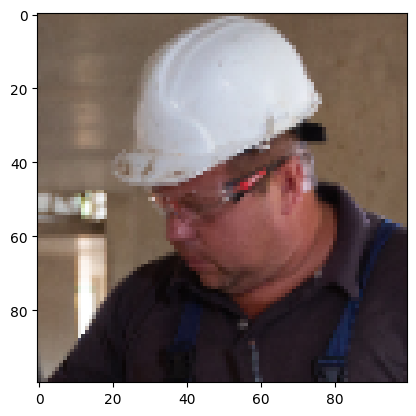

In [7]:
plt.imshow(cv.cvtColor(HeadDict['headlist'][0]['head'], cv.COLOR_BGR2RGB))

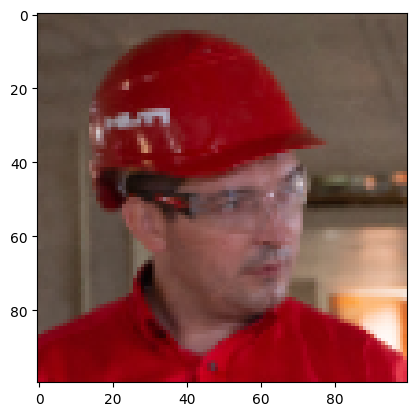

In [8]:
plt.imshow(cv.cvtColor(HeadDict['headlist'][1]['head'], cv.COLOR_BGR2RGB))

In [9]:
from Module.HeadRegion import GetHeadDict

pytorch 1.13.1+cpu
torchvision 0.14.1+cpu


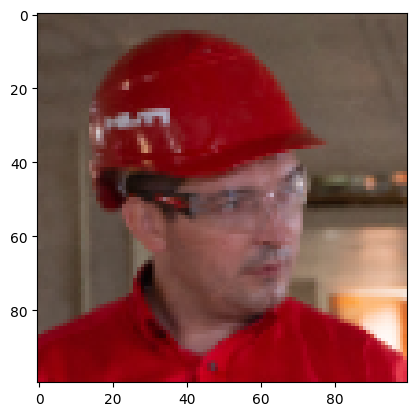

In [11]:
HeadDict = GetHeadDict(cv.imread(r'E:\GithubProjects\KagglePractice\HelmetDetection2\RawDatasets\pexels-aleksey-3680959.jpg'), (100, 100))
plt.imshow(cv.cvtColor(HeadDict['headlist'][1]['head'], cv.COLOR_BGR2RGB))